# Compare UNet deconv. trained with different sigma noise max
v>=26dec25

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('../code')) # path to your source code
sys.path.insert(0, module_path)

In [2]:
from model import *
from galaxy_img_utils import *

In [3]:
import pandas as pd

In [4]:
from utils_plot import *

# You can regenerate the Pandas DF or directly jump to the ploting section using the provided parquet file. 

# Use trained models on validation images

In [5]:
config_file = "./config_DeconvNoisy_COSMOS_4nb.yaml"


with open(config_file, "r") as config:
    settings_dict = yaml.safe_load(config)
args = SimpleNamespace(**settings_dict)

In [6]:
args

namespace(fov_pixels=48,
          pixel_scale=0.03,
          upsample=4,
          atmos_fwhm=0.4,
          atmos_e=0.01,
          sigma_defocus=0.1,
          sigma_opt_psf=0.07,
          min_shear=0.01,
          max_shear=0.05,
          opt_obs_min=0.1,
          opt_obs_width=0.4,
          lam_ov_d_min=0.017,
          lam_ov_d_width=0.007,
          sigma_noise_max=1.0,
          archi='Unet-Full',
          pool_window=2,
          num_blocks=2,
          num_kernels=64,
          num_channels=1,
          kernel_size=3,
          padding=1,
          bias=True,
          num_enc_conv=2,
          num_mid_conv=2,
          num_dec_conv=2,
          input_cosmos_dir='/lustre/fsn1/projects/rech/ixh/ufd72rp/',
          input_data_dir='../',
          input_gal_file_list='list_gal_files_48pix.json',
          models_root_dir='../models/',
          seed=116122025,
          num_workers=10,
          checkpoint_file='/Unet-Full_last_state.pth',
          history_loss_cpt_file=

In [8]:
# special for this test: 
# for all models 
args.sigma_noise_max = 1.0 # maximum sigma of the additive Gaussian noise 

In [9]:
# device cpu/gpu...
args.device = (
    torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
)

In [10]:
if args.input_gal_file_list is not None:
    # in case the original COSMOS files have been filtered (eg. minimum pixel size required)
    fname = args.input_data_dir + args.input_gal_file_list
    try:
        with open(fname, "r") as f:
            info = json.load(f)
            all_gal = info["all_gal"]
            all_psf = info["all_psf"]
            all_noise = info["all_noise"]
            all_info = info["all_info"]
    except FileNotFoundError:
        print(f"The file {fname} was not found: look for location.")
    except IOError:
        print(f"An error occurred while reading the file {fname}.")
else:
    print("input_gal_file_list not set...")

In [11]:
# Update the data location
all_gal   = [args.input_cosmos_dir + x for x in all_gal]
all_psf   = [args.input_cosmos_dir + x for x in all_psf]
all_noise = [args.input_cosmos_dir + x for x in all_noise]
all_info  = [args.input_cosmos_dir + x for x in all_info]

In [12]:
n_total = len(all_gal)
print(n_total)
assert n_total == len(all_psf), "pb n_total neq n_psf"
assert n_total == len(all_noise), "pb n_total neq n_noise"
assert n_total == len(all_info), "pb n_total neq n_info"

53923


In [13]:
sequence = np.arange(0, n_total)
# sequence of validation images not seen by any models during their training
val_seq = sequence[-args.n_val:]  

In [14]:
#overload the defualt function to fiw the noise level
def generator(args, gal_orig, psf_hst, debug=False):
    """
    args: settings
    gal_orig: original Real Galaxy extracted from catalog
    psf_hst: HST PSF associated to gal_orig
    """
    
    psf_obs,_ = gener_PSF_obs(args)
    
    # Galaxy parameters .
    gal_g = args.rng_gal_shear() # Shear of the galaxy (magnitude of the shear in the "reduced shear" definition), U(0.01, 0.05).
    gal_beta = 2.0 * np.pi * args.rng()  # Shear position angle (radians), N(0,2*pi).
    gal_mu = 1.0 + args.rng() * 0.1  # Magnification, U(1.,1.1).
    theta = np.pi/2. * np.floor(4*args.rng()) #  Rotation angle (radians), 0,pi/2,pi,3/2pi
    dx = 2 * args.rng() - 1  # Offset along x axis, U(-1,1).
    dy = 2 * args.rng() - 1  # Offset along y axis, U(-1,1).
        
    gt = get_Galaxy_img(
        gal_orig,
        psf_hst,
        gal_g=gal_g,
        gal_beta=gal_beta,
        theta=theta,
        gal_mu=gal_mu,
        dx=dx,
        dy=dy,
        fov_pixels=args.fov_pixels,
        pixel_scale=args.pixel_scale,
        upsample=args.upsample,
    )

    # Convolution with the new PSF
    conv = ifftshift(ifft2(fft2(psf_obs.clone()) * fft2(gt.clone()))).real  

    # Downsample images to desired pixel scale.
    # avoid conv, psf down_scaling as there are only intermediate steps useful for debug
    gt_full = gt.clone()
    gt  = down_sample(gt_full, args.upsample)
    conv = down_sample(conv.clone(), args.upsample)

    # Add noise
    sigma = 0.05 + (args.sigma_noise_max -0.05)*args.rng()  ################ For this Notebook
    obs = conv + torch.normal(
        mean=torch.zeros_like(conv), std=sigma * torch.ones_like(conv)
    )
    
    if debug:
        return gt, obs, gt_full, conv, psf_obs, sigma
    else:
        return gt, obs


class GalaxyDataset(Dataset):

    def __init__(
        self,
        settings,
        all_gal,
        all_psf,
        all_noise,
        all_info,
        sequence,
        debug=False
    ):
        """
        settings: run settings
        all_gal: list of galaxy FITS files
        all_psf: list of HST PSF files
        all_noise: list of noise files 
        all_info: list of additional information files        
        sequence: indexes of galaxies in the dataset
        """
        self.debug = debug
        self.settings = settings
        #
        self.all_gal   = all_gal
        self.all_psf   = all_psf
        self.all_noise = all_noise
        self.all_info  = all_info
        #
        n_gal = len(self.all_gal)
        self.seq = sequence
        
        assert n_gal >= len(self.seq), "pb n_gal < sequence length" 
        
        print("GalaxyDataset: size",len(self.seq),' among ',n_gal,'galaxies')

    def __len__(self):
        return len(self.seq)

    def __getitem__(self, idx):
        """
        Build ground truth and observation from HST galaxy
        idx : index < len(self.seq)
        """
        
        i = self.seq[idx]

        # Read out real galaxy from the catalog and the correspondig HST PSF
        gal_orig = galsim.fits.read(self.all_gal[i]) # original galaxy image
        psf      = galsim.fits.read(self.all_psf[i]) # original HST PSF
        noise    = galsim.fits.read(self.all_noise[i]) # original noise image
        with open(self.all_info[i], "r") as f:
            info = json.load(f)
            pixel_scale = info["pixel_scale"]  # original pixel_scale
            var = info['var']                  # original noise variance

        #print("GalaxyDataset gal_orig",gal_orig.array.min(),gal_orig.array.max(),gal_orig.array.sum())
        # Genetare a couple of ground truth and obersation with new PSF and snr
        psf.array = psf.array/psf.array.sum() # adjust flux to 1.0 for HST PSF
        psf_hst   = galsim.InterpolatedImage(psf)
        gal_rg    = galsim.RealGalaxy((gal_orig,psf,noise,pixel_scale,var))

        if self.debug:
             gt, obs, gt_full, conv, psf_obs, sigma = generator(self.settings, gal_rg, psf_hst, debug=True)
        else:
            gt, obs = generator(self.settings, gal_rg, psf_hst, debug=False)        
        
        # transform to CHW with C=1
        gt  = gt.unsqueeze(0)
        obs = obs.unsqueeze(0)

        if self.debug:
            return  gt, obs, gt_full, conv, psf_obs, sigma
        else:
            return gt, obs


In [15]:
ds_val  = GalaxyDataset(args,
                             all_gal,
                             all_psf,
                             all_noise,
                             all_info,
                             val_seq,
                           debug=True)


val_loader = DataLoader(
        dataset=ds_val,
        batch_size=1,
        shuffle=False,
        pin_memory=True,
        num_workers=1,
        drop_last=True,
)

GalaxyDataset: size 1000  among  53923 galaxies


## load models

In [16]:
def load_Unet(model_dir):
    model_checkpoint_file = model_dir + "Unet-Full_best_state.pth"
    model = UNet(args)
    model.to(args.device);
    checkpoint = torch.load(model_checkpoint_file)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    return model

In [17]:
models = {}

In [18]:
models_dict = {
    "dir":["Unet_cosmo_atm0d4_sigma0d01_40000train_64kernels_2blocks_MSE",
           "Unet_cosmo_atm0d4_sigma0d05_40000train_64kernels_2blocks_MSE",
           "Unet_cosmo_atm0d4_sigma0d1_40000train_64kernels_2blocks_MSE",
           "Unet_cosmo_atm0d4_sigma0d5_40000train_64kernels_2blocks_MSE",
           "Unet_cosmo_atm0d4_sigma1d0_40000train_64kernels_2blocks_MSE"
          ],
    "sigma_max":[0.01, 0.05, 0.1, 0.5, 1.0]
}
    
    


In [19]:
# single mdoel Unet ("u")
df1 = pd.DataFrame(columns=["sigma_max", "psnr_in", "psnr_u"])

In [23]:
def init_dataframe(args, models_dict):
    for i,sigma_max in enumerate(models_dict['sigma_max']):
        df1.loc[i] = {"sigma_max": sigma_max,"psnr_in":[], "psnr_u":[]}
        model_dir = args.models_root_dir + '/' + models_dict["dir"][i] + '/'
        models[sigma_max]=load_Unet(model_dir)

In [24]:
init_dataframe(args,models_dict)

In [25]:
df1

,sigma_max,psnr_in,psnr_u
0,0.01,[],[]
1,0.05,[],[]
2,0.10,[],[]
3,0.50,[],[]
4,1.00,[],[]


In [26]:
models.keys()

dict_keys([0.01, 0.05, 0.1, 0.5, 1.0])

## Analysis: Loop over validation images

In [75]:
args.sigma_noise_max = 0.5 # for generation

In [76]:
# init randoms
reset_randoms(args)


# typical timing: may last 300-700 sec for 1000 validation images
for epoch in range(1):
    for i_batch, imgs in enumerate(val_loader):
        gt, obs, gt_full, conv, psf_obs, sigma = imgs
    
        if i_batch%100 == 0 or i_batch == 0:
                print("start i_batch:",i_batch)
        #for debug
        #if i_batch>100: 
        #    break
        
        gt = gt.to(args.device)
        obs = obs.to(args.device)
        for sigma_max in models.keys():
            # save in df1
            index_ligne = df1[(df1["sigma_max"] == sigma_max)].index
            if index_ligne.empty:
                print(f"No line in df1 for fwhm_max={fwhm_max}")
                break
            #Unet deconv
            with torch.no_grad():
                output = models[sigma_max](obs)
        
            gt_img = gt.cpu().numpy().squeeze()
            obs_img = obs.cpu().numpy().squeeze()
            gt_full_img = gt_full.cpu().numpy().squeeze()
            conv_img = conv.cpu().squeeze()
            psf_obs_img = psf_obs.cpu().numpy().squeeze()
            unet_deconv_img = output.cpu().numpy().squeeze()
        
                
            #PSNR
            psnr_in = psnr(obs_img,gt_img)
            df1.at[index_ligne[0], "psnr_in"].append(psnr_in)
            psnr_unet = psnr(unet_deconv_img,gt_img)
            df1.at[index_ligne[0], "psnr_u"].append(psnr_unet)    

start i_batch: 0
start i_batch: 100
start i_batch: 200
start i_batch: 300
start i_batch: 400
start i_batch: 500
start i_batch: 600
start i_batch: 700
start i_batch: 800
start i_batch: 900


In [77]:
df1.to_parquet("single_Unet_sigmamax_fwhmmax0d4.parquet")

In [78]:
i_batch

999

# Ploting results (post analysis)

## load dataframes filled during analysis

In [27]:
df1 = pd.read_parquet("single_Unet_sigmamax_fwhmmax0d4.parquet")
sigma_max_for_gen = 0.5 # this is for the title but KEEP the same value as the one of the parquet file

In [28]:
sigma_list = df1["sigma_max"].tolist()

In [29]:
sigma_list

[0.01, 0.05, 0.1, 0.5, 1.0]

In [30]:
couleurs_temperature = [
    "#B3DFFF",  # Bleu glacier (froid)
    "#1A75FF",  # Bleu moyen
    "#33CC33",  # Vert foncé (tempéré)
    "#FF9933",  # Orange soutenu
    "#FF3333"   # Rouge foncé
]

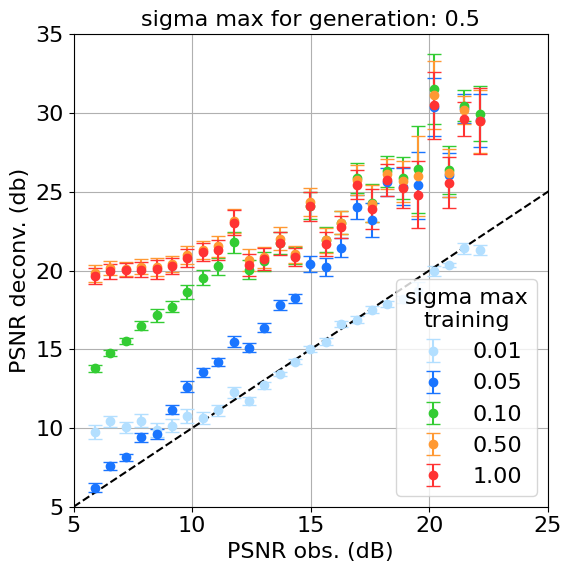

In [33]:
from matplotlib.font_manager import FontProperties

fig,ax=plt.subplots(1,1,figsize=(6,6))
for i,sigma_max in enumerate(sigma_list):

    line = df1.loc[df1["sigma_max"] == sigma_max]
    psnr_in = line["psnr_in"].iloc[0] 
    psnr_unet = line["psnr_u"].iloc[0] 
    hbprof(psnr_in, psnr_unet, n_bins=30, error_type='sem', ax=ax, label=f'{sigma_max:.2f}', 
           color=couleurs_temperature[i])
    #ax.scatter(psnr_in,psnr_unet,label=f'{sigma_max:.1f}',  s=1)


mynewline = lines.Line2D((5,35),(5,35),
                         color='k',linestyle="--")
ax.add_line(mynewline)
ax.grid()
ax.set_xlim([5,25])
ax.set_ylim([5,35]);
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(5))

#legend=ax.legend(title="FWHM max\ntraining", loc='lower right',
#          bbox_to_anchor=(1.2, 1.0))
legend=ax.legend(title="sigma max\ntraining", loc='lower right')
title = legend.get_title()
title.set_ha('center')
ax.set_ylabel("PSNR deconv. (db)")
ax.set_xlabel("PSNR obs. (dB)");
ax.set_title(f"sigma max for generation: {sigma_max_for_gen}");
plt.tight_layout();
#fig.savefig("PSNR_Unet_deconv_vs_obs_SIGMA_MAX.pdf");